# Logistic regression modeling for bad receivers identification #

The scope of this project is to model properly and train an algorithm that is able to identify bad receivers.

The data shows different receivers statistics which include some instrumentational feedbacks (capacitance, lowcut, etc..), some computed stats (root mean square of amplitude, std of RMS, etc..) and some user defined target variable (identified bad receivers).

Let's import the main libraries now

In [ ]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

from pandas import DataFrame 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.ticker as ticker
from sklearn import preprocessing

Now we import the first set of data which include have some sequence specific features, including the target feature "BAD_CHAN_FLAG" (binary, 0 good, 1 bad)

In [2]:
stats1=pd.read_csv('decode_listing_features008.csv')
stats1['SEQ']=8
stats1a=pd.read_csv('decode_listing_features003.csv')
stats1a['SEQ']=3
stats1b=pd.read_csv('decode_listing_features004.csv')
stats1b['SEQ']=4
stats1c=pd.read_csv('decode_listing_features010.csv')
stats1c['SEQ']=10
stats1d=pd.read_csv('decode_listing_features011.csv')
stats1d['SEQ']=11
stats1=stats1.append(stats1a)
stats1=stats1.append(stats1b)
stats1=stats1.append(stats1c)
stats1=stats1.append(stats1d)

In [3]:
stats1.head()

,CHANNEL,BAD_CHAN_FLAG,CAP_CUT_ERR,CAP_ERR,CAP_VAL,DEEP_RMS,LEAK_ERR,LEAK_VAL,MARG_CHAN_FLAG,SENS,SEQ
0,1,0.0,0.0,0.0,249.286484,13.73,0.0,5.0,0.0,39.88,8
1,2,0.0,0.0,0.0,248.101654,13.58,0.0,5.0,0.0,39.87,8
2,3,0.0,0.0,0.0,248.710541,15.04,0.0,5.0,0.0,39.68,8
3,4,0.0,0.0,0.0,246.606064,12.66,0.0,5.0,0.0,39.73,8
4,5,0.0,0.0,0.0,249.910889,12.54,0.0,5.0,0.0,39.82,8


Now we import the amplitude maps that will be used to derive more statistics

In [4]:
stats2=pd.read_csv('008_P_amp_maps.csv')
stats2['SEQ']=8
stats2a=pd.read_csv('003_P_amp_maps.csv')
stats2a['SEQ']=3
stats2b=pd.read_csv('004_P_amp_maps.csv')
stats2b['SEQ']=4
stats2c=pd.read_csv('010_P_amp_maps.csv')
stats2c['SEQ']=10
stats2d=pd.read_csv('011_P_amp_maps.csv')
stats2d['SEQ']=11
stats2=stats2.append(stats2a)
stats2=stats2.append(stats2b)
stats2=stats2.append(stats2c)
stats2=stats2.append(stats2d)

In [5]:
stats2.head()


,SRC_POINT,CHANNEL,WC_RMS,TGT_RMS,DEEP_RMS,WHOLE_RMS,FFID,CABLE,CABTR,SEQ
0,1001,1,20.214577,210.530777,12.440019,1045.397705,1001,1,1,8
1,1001,2,15.753899,207.250076,18.285044,1058.347046,1001,1,2,8
2,1001,3,10.252005,201.711441,14.983429,1037.041016,1001,1,3,8
3,1001,4,11.665508,202.110245,13.177336,1043.912354,1001,1,4,8
4,1001,5,12.001275,205.250626,15.401988,1018.429810,1001,1,5,8


Get standard deviation of root mean squared values, grouped by sequence and receiver number

In [6]:
std_=stats2.groupby(['SEQ','CHANNEL'])['DEEP_RMS'].agg(np.std)

In [7]:
std_=pd.DataFrame(std_)

In [8]:
std_.sort_values(['SEQ','CHANNEL'],inplace=True)
stats1.sort_values(['SEQ','CHANNEL'],inplace=True)

In [9]:
std_.reset_index(inplace=True)
len(std_)

38400

In [10]:
len(stats1)

38400

In [11]:

std_.head()

,SEQ,CHANNEL,DEEP_RMS
0,3,1,2.661812
1,3,2,2.761224
2,3,3,2.484229
3,3,4,2.525309
4,3,5,2.531213


Merge the dataframes

In [19]:
df1=pd.merge(std_,stats1 , how='left', left_on=['SEQ','CHANNEL'], right_on=['SEQ','CHANNEL'])
df2=df1.copy()

In [20]:
df2.head(10)

,SEQ,CHANNEL,DEEP_RMS_x,BAD_CHAN_FLAG,CAP_CUT_ERR,CAP_ERR,CAP_VAL,DEEP_RMS_y,LEAK_ERR,LEAK_VAL,MARG_CHAN_FLAG,SENS
0,3,1,2.661812,0.0,0.0,0.0,249.508224,14.61,0.0,5.0,0.0,38.31
1,3,2,2.761224,0.0,0.0,0.0,248.342239,14.11,0.0,5.0,0.0,38.28
2,3,3,2.484229,0.0,0.0,0.0,249.030304,14.22,0.0,5.0,0.0,38.04
3,3,4,2.525309,0.0,0.0,0.0,246.959259,13.30,0.0,5.0,0.0,38.15
4,3,5,2.531213,0.0,0.0,0.0,250.354599,13.20,0.0,5.0,0.0,38.22
5,3,6,2.494356,0.0,0.0,0.0,250.634521,13.00,0.0,5.0,0.0,38.19
6,3,7,2.464203,0.0,0.0,0.0,247.767746,12.96,0.0,5.0,0.0,38.24
7,3,8,2.424611,0.0,0.0,0.0,250.713913,12.83,0.0,5.0,0.0,38.21
8,3,9,2.457772,0.0,0.0,0.0,248.457214,12.86,0.0,5.0,0.0,38.34
9,3,10,2.430608,0.0,0.0,0.0,252.485580,12.49,0.0,5.0,0.0,38.15


# Plot Root Mean Square of amplitudes #

In [151]:
a=stats2['TGT_RMS']

In [152]:
b=a.to_list()


reshape the list for plotting

In [153]:
c= np.reshape(b,(-1,7680))
c=np.transpose(c)

just clip the value to 100 for color scaling

In [154]:
c=np.clip(c,0,100)

In [155]:
%matplotlib inline

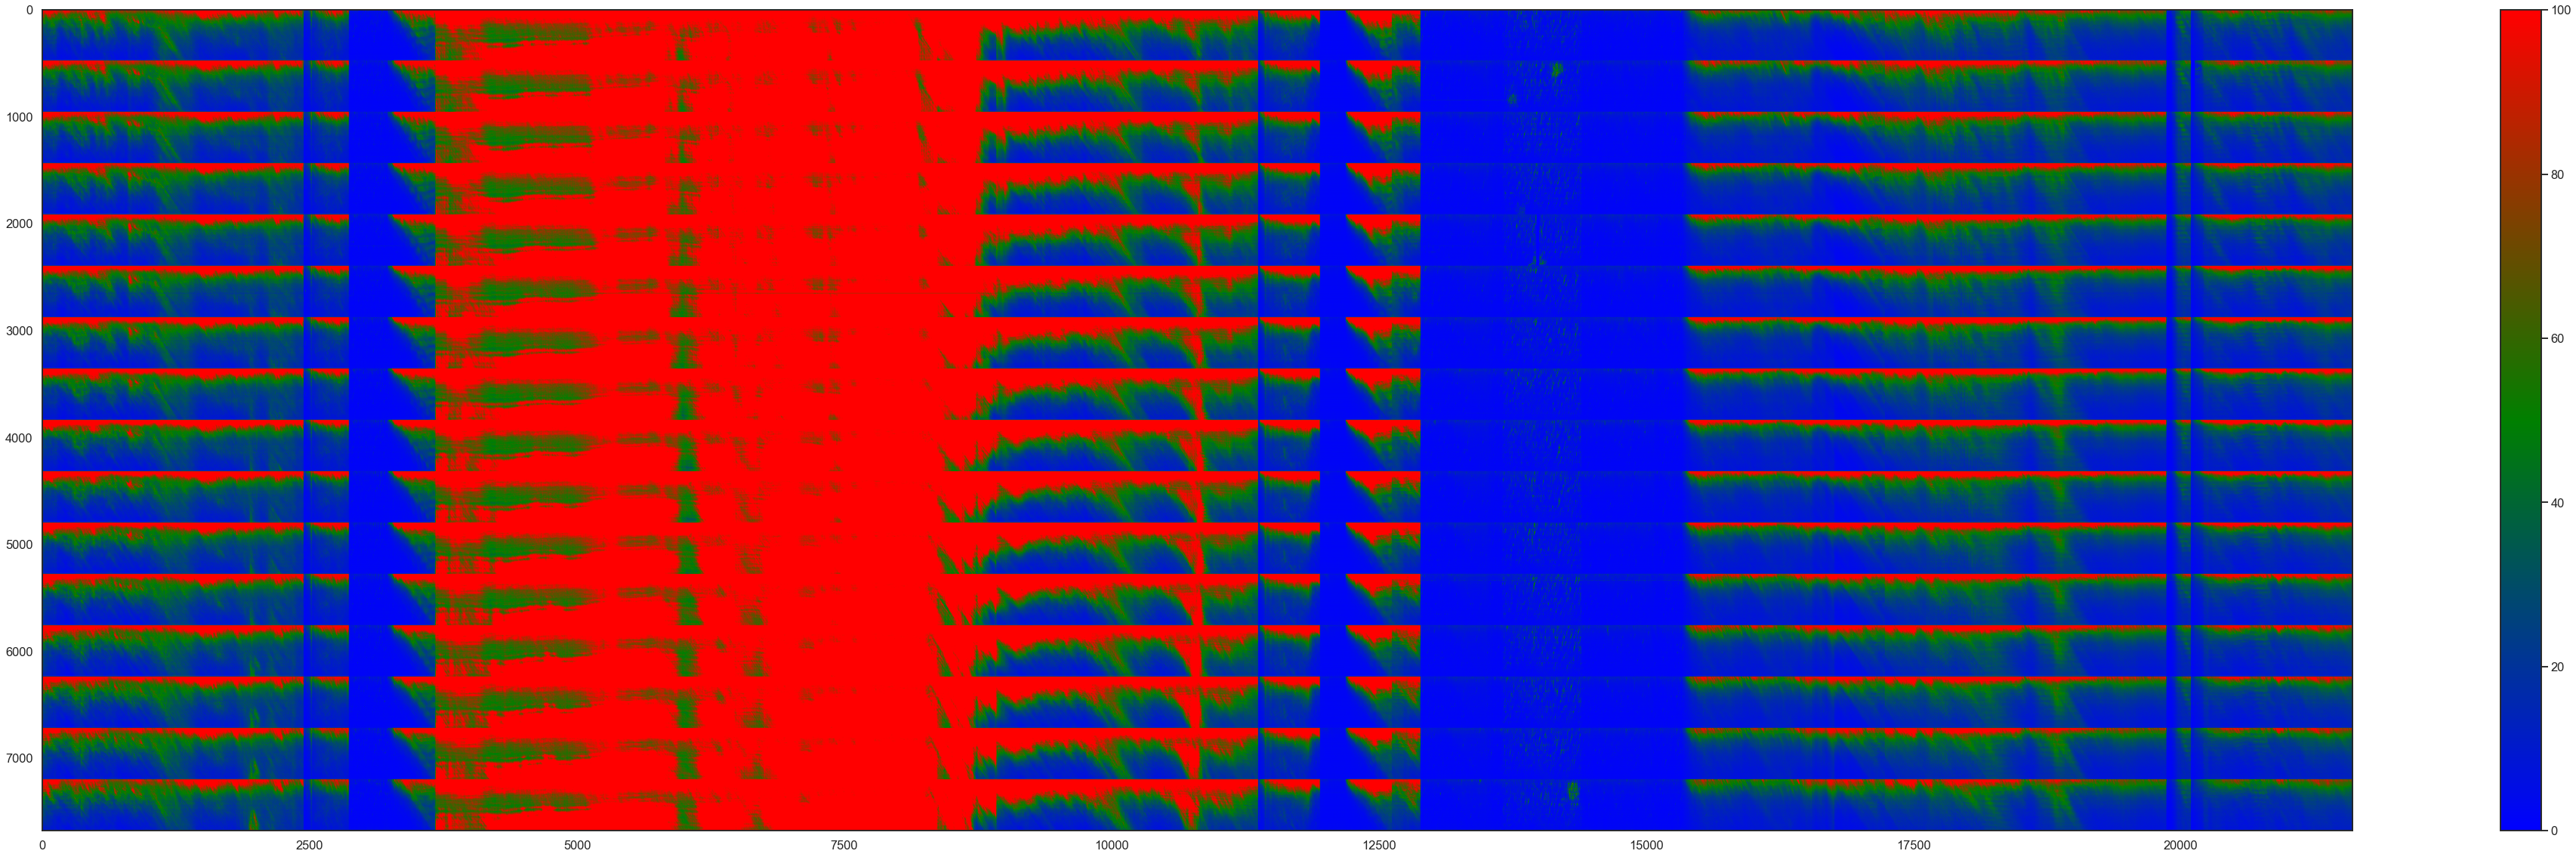

In [173]:
import matplotlib.colors as colly

cmap1= colly.LinearSegmentedColormap.from_list("" , ['blue','green','red'])

im=plt.imshow(c, cmap=cmap1)
plt.colorbar(im)
plt.rcParams["figure.figsize"] = (70,20)
plt.savefig('RMS.png')

plt.show()

## Now we start to work on the modeling ##

In [21]:
df1.head(10)

,SEQ,CHANNEL,DEEP_RMS_x,BAD_CHAN_FLAG,CAP_CUT_ERR,CAP_ERR,CAP_VAL,DEEP_RMS_y,LEAK_ERR,LEAK_VAL,MARG_CHAN_FLAG,SENS
0,3,1,2.661812,0.0,0.0,0.0,249.508224,14.61,0.0,5.0,0.0,38.31
1,3,2,2.761224,0.0,0.0,0.0,248.342239,14.11,0.0,5.0,0.0,38.28
2,3,3,2.484229,0.0,0.0,0.0,249.030304,14.22,0.0,5.0,0.0,38.04
3,3,4,2.525309,0.0,0.0,0.0,246.959259,13.30,0.0,5.0,0.0,38.15
4,3,5,2.531213,0.0,0.0,0.0,250.354599,13.20,0.0,5.0,0.0,38.22
5,3,6,2.494356,0.0,0.0,0.0,250.634521,13.00,0.0,5.0,0.0,38.19
6,3,7,2.464203,0.0,0.0,0.0,247.767746,12.96,0.0,5.0,0.0,38.24
7,3,8,2.424611,0.0,0.0,0.0,250.713913,12.83,0.0,5.0,0.0,38.21
8,3,9,2.457772,0.0,0.0,0.0,248.457214,12.86,0.0,5.0,0.0,38.34
9,3,10,2.430608,0.0,0.0,0.0,252.485580,12.49,0.0,5.0,0.0,38.15


drop one by one the features we don't need

In [22]:
df1=df1.drop('CAP_CUT_ERR',1)
df1=df1.drop('CAP_ERR',1)
df1=df1.drop('LEAK_ERR',1)
df1=df1.drop('SENS',1)
df1=df1.drop('MARG_CHAN_FLAG',1)


In [23]:
df1.head()

,SEQ,CHANNEL,DEEP_RMS_x,BAD_CHAN_FLAG,CAP_VAL,DEEP_RMS_y,LEAK_VAL
0,3,1,2.661812,0.0,249.508224,14.61,5.0
1,3,2,2.761224,0.0,248.342239,14.11,5.0
2,3,3,2.484229,0.0,249.030304,14.22,5.0
3,3,4,2.525309,0.0,246.959259,13.30,5.0
4,3,5,2.531213,0.0,250.354599,13.20,5.0


In [41]:
pd.to_numeric(df1['BAD_CHAN_FLAG'])
y=pd.DataFrame(df1['BAD_CHAN_FLAG'])
X=df1.drop(['BAD_CHAN_FLAG'],1)



In [99]:
yy=y.values.tolist()

In [43]:
X2=X.copy()
X2=X2.drop(['CHANNEL','SEQ'],1)

In [113]:

# Calculate the correlation values
feature_cols = X2.columns
corr_values = X2[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

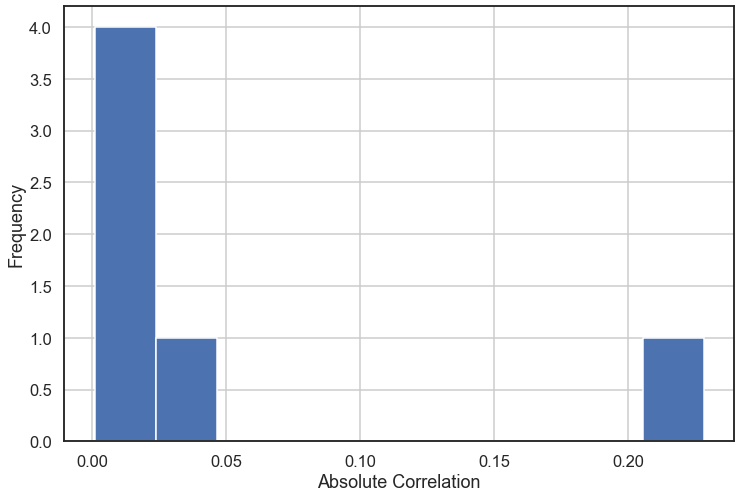

In [115]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=10, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [117]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.2')


,feature1,feature2,correlation,abs_correlation
1,DEEP_RMS_x,DEEP_RMS_y,0.22803,0.22803


# Logistic Regression #

In [44]:
XX=X2.values.tolist()

In [45]:
XX[0:5]

[[2.661812115498693, 249.508224, 14.61, 5.0],
 [2.7612244529267658, 248.342239, 14.11, 5.0],
 [2.4842293028556335, 249.030304, 14.22, 5.0],
 [2.5253092118493496, 246.95925899999997, 13.3, 5.0],
 [2.531212785253206, 250.35459900000004, 13.2, 5.0]]

use the standard scaler to normalize the dataset

In [46]:

XX= preprocessing.StandardScaler().fit(XX).transform(XX)

In [47]:
XX[0:5]

array([[-0.04726565,  0.43055594,  3.99775107,  0.04209138],
       [-0.01943756,  0.20496958,  3.76670047,  0.04209138],
       [-0.09697569,  0.33809143,  3.8175316 ,  0.04209138],
       [-0.08547635, -0.0625994 ,  3.3923985 ,  0.04209138],
       [-0.08382379,  0.59430646,  3.34618838,  0.04209138]])

test the logistic regression on the whole dataset

In [100]:
import statsmodels.api as sm
logit_model=sm.Logit(yy,XX)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.692551
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: -54.434   
Dependent Variable: y                AIC:              53195.9376
Date:               2021-09-15 13:04 BIC:              53230.1609
No. Observations:   38400            Log-Likelihood:   -26594.   
Df Model:           3                LL-Null:          -479.74   
Df Residuals:       38396            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
--------------------------------------------------------------------
       Coef.     Std.Err.       z       P>|z|      [0.025     0.975]
--------------------------------------------------------------------
x1     0.0115      0.0110     1.0486    0.2943    -0.0100     0.0330
x2    -0.0785      0.0130    -6.0489    0.0000    -0.1

let's split the data and see how it perform with the train/test

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.5, random_state=0)




In [119]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)



/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [108]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 1.00


Print the confusion matrix

In [110]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[19160     1]
 [   31     8]]


Get the main scores out to see if the model acts properly

In [111]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19161
         1.0       0.89      0.21      0.33        39

    accuracy                           1.00     19200
   macro avg       0.94      0.60      0.67     19200
weighted avg       1.00      1.00      1.00     19200



Plot the ROC curve

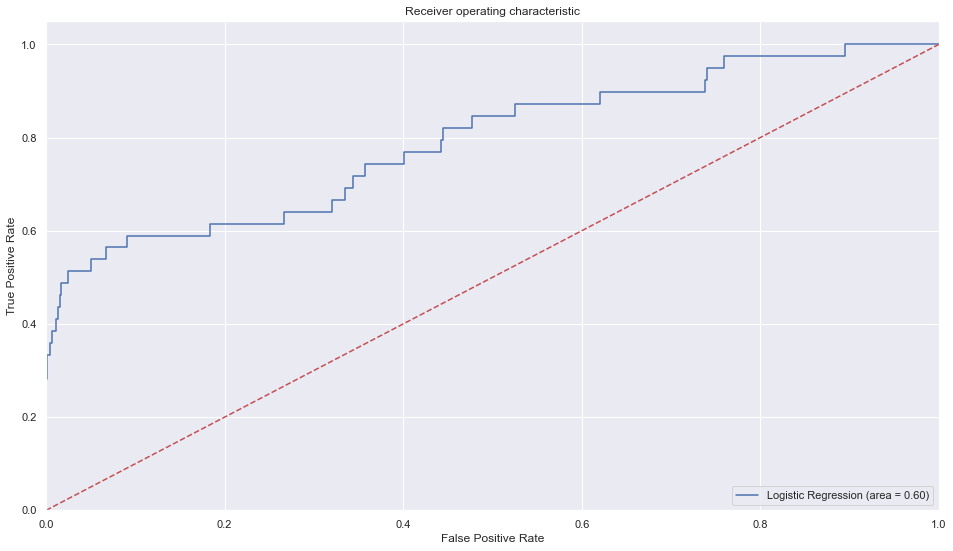

In [54]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC.png')
plt.rcParams["figure.figsize"] = (16,9)
plt.show()

a bit of workaround to get sequence and channel back into a df

In [56]:
fd=pd.DataFrame(y_pred)
fd2=pd.DataFrame(y_test)

In [57]:
fd2.head()

,BAD_CHAN_FLAG
23267,0.0
6433,0.0
19950,0.0
4075,0.0
17557,0.0


In [72]:
FD2=fd2.reset_index()
FD2.set_axis(['index','FLAG_ORIG'],axis=1,inplace=True)

In [84]:
merge=FD2.merge(fd,left_index=True, right_index=True)
merge.set_axis(['index','FLAG_ORIG','PREDICT'],axis=1,inplace=True)

In [85]:
merge.head()

,index,FLAG_ORIG,PREDICT
0,23267,0.0,0.0
1,6433,0.0,0.0
2,19950,0.0,0.0
3,4075,0.0,0.0
4,17557,0.0,0.0


create a header to spot different predictions

In [76]:
merge['DIFF']=merge['FLAG_ORIG']-merge['PREDICT']

In [77]:
finder=merge['DIFF']!=0
finder

0        False
1        False
2        False
3        False
4        False
         ...  
19195    False
19196    False
19197    False
19198    False
19199    False
Name: DIFF, Length: 19200, dtype: bool

Check what has been predicted different from the test data

In [78]:
for i,x in merge.iterrows():
    if x['DIFF']!=0:
        print(x)

INDEX        28381.0
FLAG_ORIG        1.0
PREDICT          0.0
DIFF             1.0
Name: 39, dtype: float64
INDEX        19268.0
FLAG_ORIG        1.0
PREDICT          0.0
DIFF             1.0
Name: 517, dtype: float64
INDEX        194.0
FLAG_ORIG      1.0
PREDICT        0.0
DIFF           1.0
Name: 533, dtype: float64
INDEX        251.0
FLAG_ORIG      1.0
PREDICT        0.0
DIFF           1.0
Name: 3139, dtype: float64
INDEX        23234.0
FLAG_ORIG        1.0
PREDICT          0.0
DIFF             1.0
Name: 3571, dtype: float64
INDEX        28992.0
FLAG_ORIG        1.0
PREDICT          0.0
DIFF             1.0
Name: 4994, dtype: float64
INDEX        27127.0
FLAG_ORIG        1.0
PREDICT          0.0
DIFF             1.0
Name: 5038, dtype: float64
INDEX        15002.0
FLAG_ORIG        1.0
PREDICT          0.0
DIFF             1.0
Name: 5158, dtype: float64
INDEX        11767.0
FLAG_ORIG        1.0
PREDICT          0.0
DIFF             1.0
Name: 5166, dtype: float64
INDEX        5322.0
F

In [79]:


X1_train, X1_test, y1_train, y1_test = train_test_split(df1, df1, test_size=0.5, random_state=0)

In [86]:
FD3=y1_test.reset_index()
newtest=pd.merge(FD3,merge)

In [87]:
newtest.head()

,index,SEQ,CHANNEL,DEEP_RMS_x,BAD_CHAN_FLAG,CAP_VAL,DEEP_RMS_y,LEAK_VAL,FLAG_ORIG,PREDICT
0,23267,10,228,3.124860,0.0,247.454041,4.61,5.0,0.0,0.0
1,6433,3,6434,1.831995,0.0,248.454788,6.37,5.0,0.0,0.0
2,19950,8,4591,2.081703,0.0,247.016556,4.42,5.0,0.0,0.0
3,4075,3,4076,1.581103,0.0,247.256012,5.79,5.0,0.0,0.0
4,17557,8,2198,2.479709,0.0,253.687592,4.70,5.0,0.0,0.0


In [95]:
for i,x in newtest.iterrows():
    if x['PREDICT']>x['BAD_CHAN_FLAG']:
        print(x)

index            36572.000000
SEQ                 11.000000
CHANNEL           5853.000000
DEEP_RMS_x           2.059848
BAD_CHAN_FLAG        0.000000
CAP_VAL            131.220078
DEEP_RMS_y           8.200000
LEAK_VAL             5.000000
FLAG_ORIG            0.000000
PREDICT              1.000000
Name: 9520, dtype: float64


### Let's see now how we can compare a simple lr , lr L1 norm and lr L2 norm Logistic regression ###

In [132]:


# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [133]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [134]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [135]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [136]:
y_prob.head()

,lr,l1,l2
0,0.999115,0.998161,0.993835
1,0.999098,0.998310,0.994139
2,0.999120,0.998145,0.993810
3,0.999061,0.998188,0.993833
4,0.999437,0.998763,0.995567


In [140]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
#    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
#              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
#              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy},
#                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

check the results

In [141]:
metrics

,lr,l1,l2
precision,0.998162,0.998162,0.998162
recall,0.998333,0.998333,0.998333
fscore,0.997813,0.997813,0.997813
accuracy,0.998333,0.998333,0.998333


plot the 3 confusion matrix

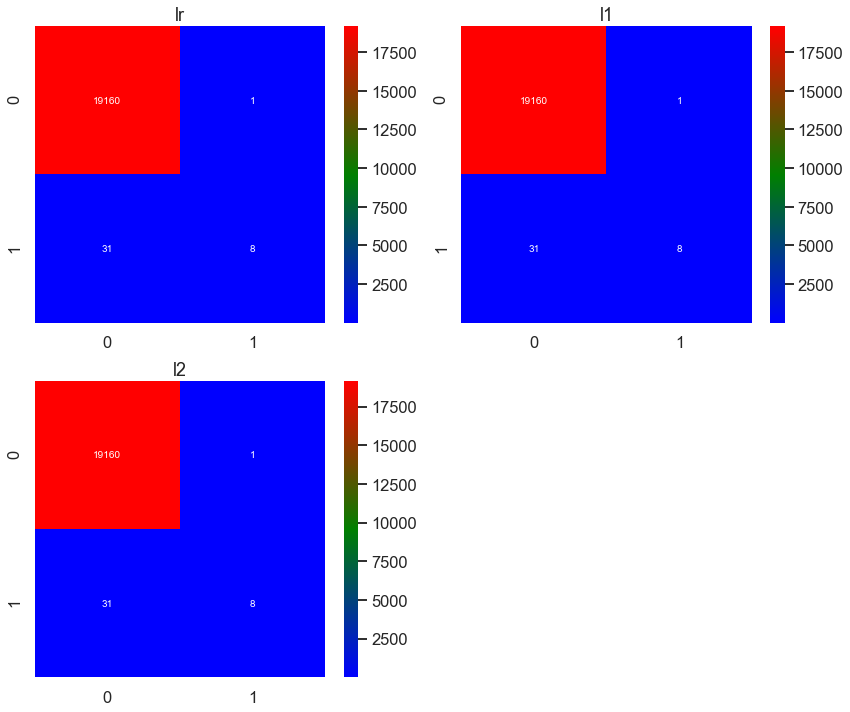

In [175]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d',cmap=cmap1);
    ax.set(title=lab);
    
plt.tight_layout()
